# !preprocessing

In [1]:
import pandas as pd
import numpy as np
import os
import sklearn.pipeline
import sklearn.tree
import sklearn.ensemble

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib
import matplotlib.pyplot as plt

In [3]:
def tokenize_text(raw_text):
    ''' Transform a plain-text string into a list of tokens
    
    We assume that *whitespace* divides tokens.
    
    Args
    ----
    raw_text : string
    
    Returns
    -------
    list_of_tokens : list of strings
        Each element is one token in the provided text
    '''
    list_of_tokens = raw_text.split() # split method divides on whitespace by default
    for pp in range(len(list_of_tokens)):
        cur_token = list_of_tokens[pp]
        # Remove punctuation
    for punc in ['?', '!', '_', '.', ',', '"', '/', "'", '(', ')']:
        cur_token = cur_token.replace(punc, "")
        # Turn to lower case
        clean_token = cur_token.lower()
        # Replace the cleaned token into the original list
        list_of_tokens[pp] = clean_token
    return list_of_tokens

In [4]:
def transform_text_into_feature_vector(text, vocab_dict):
    ''' Produce count feature vector for provided text
    
    Args
    ----
    text : string
        A string of raw text, representing a single 'review'
    vocab_dict : dict with string keys
        If token is in vocabulary, will exist as key in the dict
        If token is not in vocabulary, will not be in the dict

    Returns
    -------
    count_V : 1D numpy array, shape (V,) = (n_vocab,)
        Count vector, indicating how often each vocab word
        appears in the provided text string
    '''
    V = len(vocab_dict.keys())
    count_V = np.zeros(V)
    for tok in tokenize_text(text):
        if tok in vocab_dict:
            vv = vocab_dict[tok]
            count_V[vv] += 1
    return count_V

In [5]:
#----------------
#READ IN THE DATA
#----------------
data_dir = 'data_reviews'
x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))
x_test_df = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))

#x df has column for review and column for source website

N, n_cols = x_train_df.shape
M, m_cols = x_test_df.shape
print("Shape of x_train_df: (%d, %d)" % (N,n_cols))
print("Shape of y_train_df: %s" % str(y_train_df.shape))
print(y_train_df)

Shape of x_train_df: (2400, 2)
Shape of y_train_df: (2400, 1)
      is_positive_sentiment
0                         0
1                         0
2                         0
3                         0
4                         0
...                     ...
2395                      1
2396                      1
2397                      1
2398                      1
2399                      1

[2400 rows x 1 columns]


In [6]:
# Print out the first five rows and last five rows
tr_text_list = x_train_df['text'].values.tolist()
rows = np.arange(0, 5)
for row_id in rows:
    text = tr_text_list[row_id]
    print("row %5d | y = %d | %s" % (row_id, y_train_df.values[row_id], text))

print("...")
rows = np.arange(N - 5, N)
for row_id in rows:
    text = tr_text_list[row_id]
    print("row %5d | y = %d | %s" % (row_id, y_train_df.values[row_id], text))

row     0 | y = 0 | Oh and I forgot to also mention the weird color effect it has on your phone.
row     1 | y = 0 | THAT one didn't work either.
row     2 | y = 0 | Waste of 13 bucks.
row     3 | y = 0 | Product is useless, since it does not have enough charging current to charge the 2 cellphones I was planning to use it with.
row     4 | y = 0 | None of the three sizes they sent with the headset would stay in my ears.
...
row  2395 | y = 1 | The sweet potato fries were very good and seasoned well.
row  2396 | y = 1 | I could eat their bruschetta all day it is devine.
row  2397 | y = 1 | Ambience is perfect.
row  2398 | y = 1 | We ordered the duck rare and it was pink and tender on the inside with a nice char on the outside.
row  2399 | y = 1 | Service was good and the company was better!


In [7]:
# Print out the first five rows and last five rows
te_text_list = x_test_df['text'].values.tolist()
rows = np.arange(0, 5)
for row_id in rows:
    text = te_text_list[row_id]
    print("row %5d | y = %d | %s" % (row_id, y_train_df.values[row_id], text))

print("...")
rows = np.arange(M - 5, M)
for row_id in rows:
    text = te_text_list[row_id]
    print("row %5d | y = %d | %s" % (row_id, y_train_df.values[row_id], text))

row     0 | y = 0 | It only recognizes the Phone as its storage device.
row     1 | y = 0 | Disappointing accessory from a good manufacturer.
row     2 | y = 0 | The one big drawback of the MP3 player is that the buttons on the phone's front cover that let you pause and skip songs lock out after a few seconds.
row     3 | y = 0 | This particular model would not work with my Motorola Q smartphone.
row     4 | y = 0 | If the two were seperated by a mere 5+ ft I started to notice excessive static and garbled sound from the headset.
...
row   595 | y = 1 | Everything was fresh and delicious!
row   596 | y = 1 | - Really, really good rice, all the time.
row   597 | y = 1 | Pretty awesome place.
row   598 | y = 1 | The staff are great, the ambiance is great.
row   599 | y = 1 | The patio seating was very comfortable.


In [8]:
#----------------
#DATA CLEANUP
#----------------

tok_count_dict = dict()

for line in tr_text_list:
    tok_list = tokenize_text(line)
    for tok in tok_list:
        if tok in tok_count_dict:
            tok_count_dict[tok] += 1
        else:
            tok_count_dict[tok] = 1
#tok_count_dict holds words paired with # occurences

In [9]:
#print top 10 as sanity check
sorted_tokens = list(sorted(tok_count_dict, key=tok_count_dict.get, reverse=True))
for w in sorted_tokens[:10]:
    print("%5d %s" % (tok_count_dict[w], w))

 1184 the
  894 and
  677 a
  674 I
  598 is
  535 to
  484 of
  447 was
  400 it
  373 The


In [10]:
#select words with at least 4 occurrences and less than 300 occurrences
vocab_list = [w for w in sorted_tokens if (tok_count_dict[w] >= 3) and (tok_count_dict[w] <= 300)]
print(len(vocab_list))

1236


In [11]:
#pair tokens with unique id for vectorizing
vocab_dict = dict()
for vocab_id, tok in enumerate(vocab_list):
    vocab_dict[tok] = vocab_id

x_tr_NV = np.zeros((len(tr_text_list), len(vocab_list)))
for nn, raw_text_line in enumerate(tr_text_list):
    x_tr_NV[nn] = transform_text_into_feature_vector(raw_text_line, vocab_dict)
print(x_tr_NV.shape)

x_te_MV = np.zeros((len(te_text_list), len(vocab_list)))
for nn, raw_text_line in enumerate(te_text_list):
    x_te_MV[nn] = transform_text_into_feature_vector(raw_text_line, vocab_dict)
print(x_te_MV.shape)

(2400, 1236)
(600, 1236)


In [107]:
#model setup
tree = sklearn.tree.DecisionTreeClassifier(
    criterion='gini', min_samples_split=2, min_samples_leaf=1)
hyperparameter_grid_by_name = dict(
    max_depth=[32, 128, 256],
    min_samples_leaf=[1, 3, 9],
    )

In [108]:
#model definition
grid = sklearn.model_selection.GridSearchCV(
    tree,
    hyperparameter_grid_by_name,
    scoring='balanced_accuracy',
    cv=7,
    return_train_score=True)

In [12]:
grid.fit(x_tr_NV, y_train_df['is_positive_sentiment'])

GridSearchCV(cv=7, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [32, 128, 256],
                         'min_samples_leaf': [1, 3, 9]},
             return_train_score=True, scoring='balanced_accuracy')

In [13]:
tree_search_results_df = pd.DataFrame(grid.cv_results_).copy()
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 128, 'min_samples_leaf': 3}
0.7466825979677877


In [84]:
#BIGRAMS
two_gram_preprocessor = CountVectorizer(binary=False, ngram_range=(2,2), min_df=4, max_df=0.1)

In [85]:
two_gram_preprocessor.fit(tr_text_list)

CountVectorizer(max_df=0.1, min_df=4, ngram_range=(2, 2))

In [86]:
len(two_gram_preprocessor.vocabulary_)

707

In [17]:
for term, count in two_gram_preprocessor.vocabulary_.items():
    print("%4d %s" % (count, term))

 486 it has
 654 on your
1153 your phone
 782 that one
 215 didn work
1054 waste of
 705 product is
 750 since it
 479 it does
 220 does not
 605 not have
 968 to use
 506 it with
 597 none of
 635 of the
 880 the three
1105 with the
 831 the headset
 402 in my
 578 my ears
 206 customer service
 455 is still
 667 out and
 847 the only
1003 very disappointing
 906 thing was
 896 there was
1039 was no
1002 very disappointed
 869 the service
 743 service was
1053 was very
1000 very bad
 658 only thing
 905 thing that
 460 is the
 351 had to
 481 it feels
 216 difficult to
  75 and the
 171 buttons are
 105 are so
 781 that it
 489 it is
 548 make the
 863 the same
 723 same mistake
 759 sound and
 218 do not
 598 not be
 639 of time
 217 disappointed with
1101 with my
 527 like the
 265 felt like
 526 like it
 509 it would
 157 bluetooth headset
 970 to wear
1062 we have
  78 and they
 706 put on
 922 this product
 227 down the
1127 would not
 612 not recommend
 720 recommend this
 917 t

In [67]:
pipeline = sklearn.pipeline.Pipeline([
    ('my_bow_feature_extractor', CountVectorizer(binary=False, ngram_range=(2,2), min_df=0, max_df=0.75)),
    ('my_classifier', tree),
])

In [68]:
tree = sklearn.tree.DecisionTreeClassifier(
    criterion='gini', min_samples_split=2, min_samples_leaf=1)
hyperparameter_grid_by_name = dict(
    my_classifier__max_depth=[32, 128, 256],
    my_classifier__min_samples_leaf=[1, 3, 9],
    )

In [69]:
#model definition
grid2 = sklearn.model_selection.GridSearchCV(
    pipeline,
    hyperparameter_grid_by_name,
    scoring='balanced_accuracy',
    cv=7,
    return_train_score=True)

In [70]:
grid2.fit(tr_text_list, y_train_df['is_positive_sentiment'])

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('my_bow_feature_extractor',
                                        CountVectorizer(max_df=0.75, min_df=0,
                                                        ngram_range=(2, 2))),
                                       ('my_classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'my_classifier__max_depth': [32, 128, 256],
                         'my_classifier__min_samples_leaf': [1, 3, 9]},
             return_train_score=True, scoring='balanced_accuracy')

In [71]:
tree_search_results_df = pd.DataFrame(grid2.cv_results_).copy()
print(grid2.best_params_)
print(grid2.best_score_)

{'my_classifier__max_depth': 256, 'my_classifier__min_samples_leaf': 1}
0.6218477395037983


In [140]:
lasso = sklearn.linear_model.LogisticRegression(
    penalty='l1', solver='saga', random_state=101)

In [141]:
lasso_hyperparameter_grid_by_name = dict(
    C=np.logspace(-2, 2, 9),
    max_iter=[20, 40], # sneaky way to do "early stopping" 
                       # we'll take either iter 20 or iter 40 in training process, by best valid performance
    )

In [142]:
lasso_searcher = sklearn.model_selection.GridSearchCV(
    lasso,
    lasso_hyperparameter_grid_by_name,
    scoring='balanced_accuracy',
    cv=7,
    return_train_score=True,
    refit=False)

In [143]:
lasso_searcher.fit(x_tr_NV, y_train_df['is_positive_sentiment'])

C:\Users\ethan\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\ethan\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\ethan\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\ethan\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\ethan\miniconda3\envs\comp1

C:\Users\ethan\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\ethan\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\ethan\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\ethan\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\ethan\miniconda3\envs\comp1

C:\Users\ethan\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\ethan\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\ethan\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\ethan\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\ethan\miniconda3\envs\comp1

GridSearchCV(cv=7,
             estimator=LogisticRegression(penalty='l1', random_state=101,
                                          solver='saga'),
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'max_iter': [20, 40]},
             refit=False, return_train_score=True, scoring='balanced_accuracy')

In [144]:
lasso_search_results_df = pd.DataFrame(lasso_searcher.cv_results_).copy()
print(lasso_searcher.best_params_)
print(lasso_searcher.best_score_)

{'C': 10.0, 'max_iter': 20}
0.8116487925239456


# FOREST

In [28]:
forest = sklearn.ensemble.RandomForestClassifier(
    n_estimators=125,
    criterion='gini',
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=1)

In [29]:
pipeline = sklearn.pipeline.Pipeline([
    ('my_bow_feature_extractor', CountVectorizer(ngram_range=(2,2), min_df=3, max_df=0.75)),
    ('my_classifier', forest),
])

In [109]:
forest_hyperparameter_grid_by_name = dict(
    max_features=[3, 10, 33],
    max_depth=[32, 64, 128],
    min_samples_leaf=[1],
    n_estimators=[100, 125],
    )

In [110]:
# TODO construct a GridSearchCV object like you did above.

forest_searcher = sklearn.model_selection.GridSearchCV(
    forest,
    forest_hyperparameter_grid_by_name,
    scoring='balanced_accuracy',
    cv=7,
    return_train_score=True,
    refit=False)

In [111]:
forest_searcher.fit(x_tr_NV, y_train_df['is_positive_sentiment'])

GridSearchCV(cv=7,
             estimator=RandomForestClassifier(max_depth=15, n_estimators=125),
             param_grid={'max_depth': [32, 64, 128],
                         'max_features': [3, 10, 33], 'min_samples_leaf': [1],
                         'n_estimators': [100, 125]},
             refit=False, return_train_score=True, scoring='balanced_accuracy')

In [112]:
forest_search_results = pd.DataFrame(forest_searcher.cv_results_).copy()
print(forest_searcher.best_params_)
print(forest_searcher.best_score_)

{'max_depth': 128, 'max_features': 10, 'min_samples_leaf': 1, 'n_estimators': 125}
0.813798061044083


In [113]:
best_forest_searcher = sklearn.ensemble.RandomForestClassifier(
    n_estimators=forest_searcher.best_params_['n_estimators'],
    criterion='gini',
    max_depth=forest_searcher.best_params_['max_depth'],
    min_samples_split=2,
    min_samples_leaf=forest_searcher.best_params_['min_samples_leaf'],
    max_features=forest_searcher.best_params_['max_features'])

In [114]:
best_forest_searcher.fit(x_tr_NV, y_train_df['is_positive_sentiment'])

RandomForestClassifier(max_depth=128, max_features=10, n_estimators=125)

In [115]:
yproba1_test = best_forest_searcher.predict_proba(x_te_MV)[:, 1]

In [116]:
print(te_text_list[3])

This particular model would not work with my Motorola Q smartphone.


In [117]:
for i in yproba1_test:
    print(i)

0.5043422129961836
0.5319591574677418
0.4488324233482732
0.16057669444198383
0.44859358686427997
0.20954905275512328
0.2852095146994915
0.3228902703259924
0.38222165166975625
0.5728638837171081
0.4164822107268446
0.4447668630480029
0.27264092503603365
0.1056698394153147
0.41284628152219743
0.252208004827294
0.19615549707408644
0.2779757459971956
0.3579717467894207
0.5243698521863919
0.4234387286690858
0.4181054931259095
0.38594037163595585
0.4280601359382071
0.3689300569211182
0.45094445030483365
0.21723435749759962
0.5784909462933995
0.2690010002913763
0.36766825568740585
0.509856111463903
0.44391364023221025
0.42333948957029993
0.2130447286133325
0.3821612232128116
0.49037965381214915
0.4609766269291265
0.15066249359745298
0.12507462571051495
0.49251885576026366
0.1924954605194309
0.22657668267239658
0.4283271585097008
0.3366501381034028
0.38883467151276907
0.22748984708730735
0.33218271210230693
0.42032561705513055
0.29260122205475475
0.2690010002913763
0.27232555933653674
0.2347787

# TF/IDF forest

In [218]:
forest1 = sklearn.ensemble.RandomForestClassifier(
    n_estimators=125,
    criterion='gini',
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=1)
forest1_hyperparameter_grid_by_name = dict(
    forest__max_features=[3, 10, 33],
    forest__max_depth=[16, 32, 64, 128, 256],
    forest__min_samples_leaf=[1],
    forest__n_estimators=[125],
    )

In [219]:

pipeline = sklearn.pipeline.Pipeline([
    ('tfidf', TfidfVectorizer(binary=False, strip_accents='ascii', ngram_range=(1,1), min_df=0, max_df=300)),
    ('forest', forest1),
])

In [220]:
forest_searcher1 = sklearn.model_selection.GridSearchCV(
    pipeline,
    forest1_hyperparameter_grid_by_name,
    scoring='balanced_accuracy',
    cv=7,
    return_train_score=True,
    refit=False)

In [221]:
forest_searcher1.fit(tr_text_list, y_train_df['is_positive_sentiment'])

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=300, min_df=0,
                                                        strip_accents='ascii')),
                                       ('forest',
                                        RandomForestClassifier(max_depth=15,
                                                               n_estimators=125))]),
             param_grid={'forest__max_depth': [16, 32, 64, 128, 256],
                         'forest__max_features': [3, 10, 33],
                         'forest__min_samples_leaf': [1],
                         'forest__n_estimators': [125]},
             refit=False, return_train_score=True, scoring='balanced_accuracy')

In [224]:
forest_search_results1 = pd.DataFrame(forest_searcher1.cv_results_).copy()
print(forest_searcher1.best_params_)
print(forest_searcher1.best_score_)
print(forest_search_results1['params'])

{'forest__max_depth': 128, 'forest__max_features': 33, 'forest__min_samples_leaf': 1, 'forest__n_estimators': 125}
0.8067358318276311
0     {'forest__max_depth': 16, 'forest__max_feature...
1     {'forest__max_depth': 16, 'forest__max_feature...
2     {'forest__max_depth': 16, 'forest__max_feature...
3     {'forest__max_depth': 32, 'forest__max_feature...
4     {'forest__max_depth': 32, 'forest__max_feature...
5     {'forest__max_depth': 32, 'forest__max_feature...
6     {'forest__max_depth': 64, 'forest__max_feature...
7     {'forest__max_depth': 64, 'forest__max_feature...
8     {'forest__max_depth': 64, 'forest__max_feature...
9     {'forest__max_depth': 128, 'forest__max_featur...
10    {'forest__max_depth': 128, 'forest__max_featur...
11    {'forest__max_depth': 128, 'forest__max_featur...
12    {'forest__max_depth': 256, 'forest__max_featur...
13    {'forest__max_depth': 256, 'forest__max_featur...
14    {'forest__max_depth': 256, 'forest__max_featur...
Name: params, dtype: objec

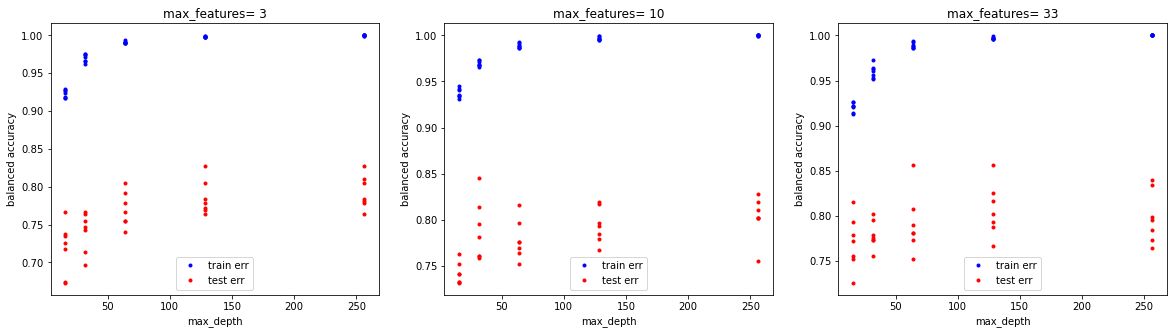

In [229]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for plotid in range(3):
    cs = np.asarray([0, 3, 6, 9, 12])
    cs = cs + plotid
    c_ax = []
    tr_error = []
    te_error = []
    for i in cs:
        tr_error.append(forest_search_results1['split0_train_score'][i])
        tr_error.append(forest_search_results1['split1_train_score'][i])
        tr_error.append(forest_search_results1['split2_train_score'][i])
        tr_error.append(forest_search_results1['split3_train_score'][i])
        tr_error.append(forest_search_results1['split4_train_score'][i])
        tr_error.append(forest_search_results1['split5_train_score'][i])
        tr_error.append(forest_search_results1['split6_train_score'][i])
        te_error.append(forest_search_results1['split0_test_score'][i])
        te_error.append(forest_search_results1['split1_test_score'][i])
        te_error.append(forest_search_results1['split2_test_score'][i])
        te_error.append(forest_search_results1['split3_test_score'][i])
        te_error.append(forest_search_results1['split4_test_score'][i])
        te_error.append(forest_search_results1['split5_test_score'][i])
        te_error.append(forest_search_results1['split6_test_score'][i])
        for j in range(7):
            c_ax.append(forest_search_results1['param_forest__max_depth'][i])
    axs[plotid].plot(c_ax, tr_error, 'b.', label='train err')
    axs[plotid].plot(c_ax, te_error, 'r.', label='test err')
    axs[plotid].set(title='max_features= ' + str(forest_search_results1['param_forest__max_features'][cs[0]]))
    axs[plotid].set_xlabel('max_depth');
    #axs[plotid].set_xscale('log')
    axs[plotid].set_ylabel('balanced accuracy');
    axs[plotid].legend(loc='lower center')

# TF/IDF Logistic w early stopping (BEST ONE)

In [12]:
lasso1 = sklearn.linear_model.LogisticRegression(
    penalty='l2', solver='lbfgs', random_state=101)
pipelinelassotfidf = sklearn.pipeline.Pipeline([
    ('tfidf', TfidfVectorizer(binary=False, strip_accents='ascii', ngram_range=(1,1), min_df=0, max_df=300)),
    ('lasso', lasso1),
])

In [13]:
lasso_hyperparameter_grid_by_name = dict(
    lasso__C=np.logspace(-1, 2, 7),
    lasso__max_iter=[20, 25, 30, 35, 40], # sneaky way to do "early stopping" 
                       # we'll take either iter 20 or iter 40 in training process, by best valid performance
    )

In [14]:
lasso_searcher1 = sklearn.model_selection.GridSearchCV(
    pipelinelassotfidf,
    lasso_hyperparameter_grid_by_name,
    scoring='balanced_accuracy',
    cv=7,
    return_train_score=True,
    refit=False)

In [15]:
lasso_searcher1.fit(tr_text_list, y_train_df['is_positive_sentiment'])

C:\Users\hanke\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hanke\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

C:\Users\hanke\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hanke\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

C:\Users\hanke\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hanke\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

C:\Users\hanke\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hanke\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

C:\Users\hanke\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hanke\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

C:\Users\hanke\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hanke\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

C:\Users\hanke\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hanke\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

C:\Users\hanke\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hanke\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=300, min_df=0,
                                                        strip_accents='ascii')),
                                       ('lasso',
                                        LogisticRegression(random_state=101))]),
             param_grid={'lasso__C': array([  0.1       ,   0.31622777,   1.        ,   3.16227766,
        10.        ,  31.6227766 , 100.        ]),
                         'lasso__max_iter': [20, 25, 30, 35, 40]},
             refit=False, return_train_score=True, scoring='balanced_accuracy')

In [16]:
lasso_search_results_df = pd.DataFrame(lasso_searcher1.cv_results_).copy()
print(lasso_searcher1.best_params_)
print(lasso_searcher1.best_score_)

{'lasso__C': 3.1622776601683795, 'lasso__max_iter': 20}
0.8329156223893065


In [179]:
best_lasso = sklearn.linear_model.LogisticRegression(
    penalty='l2', solver='lbfgs', random_state=101,
    C = lasso_searcher1.best_params_['lasso__C'],
    max_iter=lasso_searcher1.best_params_['lasso__max_iter'])

In [180]:
best_pipeline = sklearn.pipeline.Pipeline([
    ('tfidf', TfidfVectorizer(binary=False, strip_accents='ascii', ngram_range=(1,1), min_df=0, max_df=300)),
    ('lasso', best_lasso),
])

In [181]:
best_pipeline.fit(tr_text_list, y_train_df['is_positive_sentiment'])

C:\Users\ethan\miniconda3\envs\comp135_2020f_env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=300, min_df=0, strip_accents='ascii')),
                ('lasso',
                 LogisticRegression(C=3.1622776601683795, max_iter=20,
                                    random_state=101))])

In [182]:
yproba1_test = best_pipeline.predict_proba(te_text_list)[:, 1]

In [183]:
for i in yproba1_test:
    print(i)

0.5614290242260139
0.4262841693145981
0.20093786619181872
0.09911932600333899
0.37031768298436474
0.09547537263138066
0.0812260662022352
0.20014390158203466
0.3045590218218235
0.521777454272951
0.4399312923634177
0.5478157582410996
0.0984406795326879
0.07605207738219627
0.40000012624522074
0.15316129078452564
0.08939064094021286
0.11866147924991506
0.39578988494100914
0.6414369265084412
0.34650634352346765
0.4179701718360477
0.32340590555934373
0.2866305978090198
0.41967007000322476
0.4518514899947352
0.30775223873623214
0.4659619816904992
0.1818653983752449
0.2776550851117747
0.4979556076644921
0.3061231199797589
0.3843828598431947
0.03630871943395882
0.2915638920063214
0.3429327971869
0.3683339893185344
0.0883116045599676
0.3684433106462046
0.486621355043422
0.022049372630290352
0.09618170100755306
0.4386203097705175
0.25865588704302417
0.3570572814968558
0.07490359776804927
0.23941657582391088
0.2417505816043391
0.07439047722716148
0.1818653983752449
0.06507328943421066
0.1082870674

## hyperparam plt

In [185]:
lasso_search_results_df = pd.DataFrame(lasso_searcher1.cv_results_).copy()

In [186]:
print(lasso_search_results_df['params'])

0              {'lasso__C': 0.1, 'lasso__max_iter': 20}
1              {'lasso__C': 0.1, 'lasso__max_iter': 25}
2              {'lasso__C': 0.1, 'lasso__max_iter': 30}
3              {'lasso__C': 0.1, 'lasso__max_iter': 35}
4              {'lasso__C': 0.1, 'lasso__max_iter': 40}
5     {'lasso__C': 0.31622776601683794, 'lasso__max_...
6     {'lasso__C': 0.31622776601683794, 'lasso__max_...
7     {'lasso__C': 0.31622776601683794, 'lasso__max_...
8     {'lasso__C': 0.31622776601683794, 'lasso__max_...
9     {'lasso__C': 0.31622776601683794, 'lasso__max_...
10             {'lasso__C': 1.0, 'lasso__max_iter': 20}
11             {'lasso__C': 1.0, 'lasso__max_iter': 25}
12             {'lasso__C': 1.0, 'lasso__max_iter': 30}
13             {'lasso__C': 1.0, 'lasso__max_iter': 35}
14             {'lasso__C': 1.0, 'lasso__max_iter': 40}
15    {'lasso__C': 3.1622776601683795, 'lasso__max_i...
16    {'lasso__C': 3.1622776601683795, 'lasso__max_i...
17    {'lasso__C': 3.1622776601683795, 'lasso__m

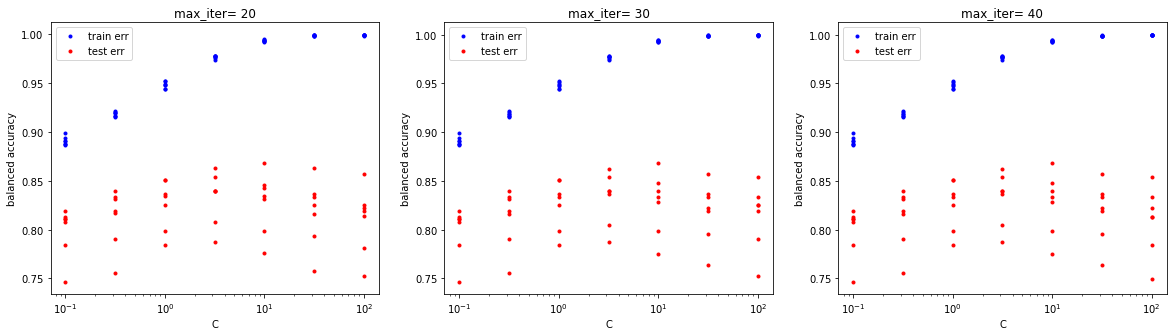

In [217]:
# max iter: fix to 20
# c: 0, 5, 10, 15, 20, 25, 30

cs = [0, 5, 10, 15, 20, 25, 30]
c_ax = []
tr_error = []
te_error = []
for i in cs:
    tr_error.append(lasso_search_results_df['split0_train_score'][i])
    tr_error.append(lasso_search_results_df['split1_train_score'][i])
    tr_error.append(lasso_search_results_df['split2_train_score'][i])
    tr_error.append(lasso_search_results_df['split3_train_score'][i])
    tr_error.append(lasso_search_results_df['split4_train_score'][i])
    tr_error.append(lasso_search_results_df['split5_train_score'][i])
    tr_error.append(lasso_search_results_df['split6_train_score'][i])
    te_error.append(lasso_search_results_df['split0_test_score'][i])
    te_error.append(lasso_search_results_df['split1_test_score'][i])
    te_error.append(lasso_search_results_df['split2_test_score'][i])
    te_error.append(lasso_search_results_df['split3_test_score'][i])
    te_error.append(lasso_search_results_df['split4_test_score'][i])
    te_error.append(lasso_search_results_df['split5_test_score'][i])
    te_error.append(lasso_search_results_df['split6_test_score'][i])
    for j in range(7):
        c_ax.append(lasso_search_results_df['param_lasso__C'][i])

#asdf
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for plotid in range(3):
    cs = np.asarray([0, 5, 10, 15, 20, 25, 30])
    cs = cs + 2*plotid
    c_ax = []
    tr_error = []
    te_error = []
    for i in cs:
        tr_error.append(lasso_search_results_df['split0_train_score'][i])
        tr_error.append(lasso_search_results_df['split1_train_score'][i])
        tr_error.append(lasso_search_results_df['split2_train_score'][i])
        tr_error.append(lasso_search_results_df['split3_train_score'][i])
        tr_error.append(lasso_search_results_df['split4_train_score'][i])
        tr_error.append(lasso_search_results_df['split5_train_score'][i])
        tr_error.append(lasso_search_results_df['split6_train_score'][i])
        te_error.append(lasso_search_results_df['split0_test_score'][i])
        te_error.append(lasso_search_results_df['split1_test_score'][i])
        te_error.append(lasso_search_results_df['split2_test_score'][i])
        te_error.append(lasso_search_results_df['split3_test_score'][i])
        te_error.append(lasso_search_results_df['split4_test_score'][i])
        te_error.append(lasso_search_results_df['split5_test_score'][i])
        te_error.append(lasso_search_results_df['split6_test_score'][i])
        for j in range(7):
            c_ax.append(lasso_search_results_df['param_lasso__C'][i])
    axs[plotid].plot(c_ax, tr_error, 'b.', label='train err')
    axs[plotid].plot(c_ax, te_error, 'r.', label='test err')
    axs[plotid].set(title='max_iter= ' + str(lasso_search_results_df['param_lasso__max_iter'][cs[0]]))
    axs[plotid].set_xlabel('C');
    axs[plotid].set_xscale('log')
    axs[plotid].set_ylabel('balanced accuracy');
    axs[plotid].legend(loc='upper left')

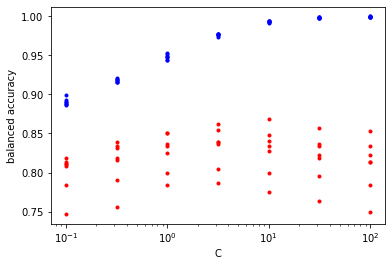

In [211]:
plt.plot(c_ax, tr_error, 'b.');
plt.plot(c_ax, te_error, 'r.')
plt.xlabel('C');
plt.xscale('log')
plt.ylabel('balanced accuracy');

# false negatives and positives

In [237]:
yhat_tr = best_pipeline.predict_proba(tr_text_list)[:, 1]
print(yhat_tr)

[0.45031251 0.0928501  0.16057846 ... 0.90178422 0.79656958 0.86583651]


In [238]:
count1 = 0
count2 = 0
false_pos = []
false_neg = []
for i in range(yhat_tr.shape[0]):
    #false pos
    if yhat_tr[i] > 0.5 and y_train_df['is_positive_sentiment'][i] == 0 and count1 < 9:
        false_pos.append(i)
        count1 += 1
    #false neg
    if yhat_tr[i] < 0.5 and y_train_df['is_positive_sentiment'][i] == 1 and count2 < 9:
        false_neg.append(i)
        count2 += 1
print(false_pos)

[53, 54, 193, 204, 804, 945, 991, 1033, 1065]


In [242]:
print("-----predicted positive but should be negative------\n")
for i in range(9):
    print(tr_text_list[false_pos[i]])
print("\n\n-----predicted negative but should be positive------\n")
for i in range(9):
    print(tr_text_list[false_neg[i]])

-----predicted positive but should be negative------

I really wanted the Plantronics 510 to be the right one, but it has too many issues for me.The good
Excellent starter wireless headset.
The loudspeaker option is great, the bumpers with the lights is very ... appealing.
If you plan to use this in a car forget about it.
Graphics is far from the best part of the game.  
I'm so sorry but I really can't recommend it to anyone.  
The only place good for this film is in the garbage.  
All in all, a great disappointment.  
The guy who said he's had better dialogue with his potted plants has it right.  


-----predicted negative but should be positive------

Plan on ordering from them again and again.
I really like this product over the Motorola because it is allot clearer on the ear piece and the mic.
good protection and does not make phone too bulky.
You get extra minutes so that you can carry out the call and not get cut off."
Because both ears are occupied, background is not distracting